Problem statement: https://ovgu-ailab.github.io/lgm2021/ass6.html

References used:

https://www.tensorflow.org/tutorials/generative/cvae

https://keras.io/examples/generative/vae/

https://www.youtube.com/watch?v=8wrLjnQ7EWQ

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs Available: ",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs Available:  1


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(28, 28)


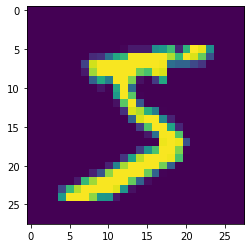

In [3]:
# Load MNIST Data set.
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
print(train_labels.shape)
print(train_images[0].shape)
#show the first image.
plt.imshow(train_images[0])

In [4]:
from sklearn.preprocessing import Binarizer
bin = Binarizer(threshold=0.5)
def reshape_img(data):
  nsamples , nx , ny = data.shape
  return data.reshape(data.shape[0], nx, ny,1).astype('float32') / 255.0

In [5]:
train_img = reshape_img(train_images)
test_img = reshape_img(test_images)
print(train_img.shape)
train_data = tf.data.Dataset.from_tensor_slices(train_img.astype(np.float32))
train_data = train_data.shuffle(buffer_size=60000).batch(128,drop_remainder=True)

print(test_img.shape)
#test_data = tf.data.Dataset.from_tensor_slices(test_img.astype(np.float32))
#test_data = test_data.shuffle(buffer_size=60000).batch(128,drop_remainder=True)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
def reparameterize(z_mean,z_log_var):
  batch = tf.shape(z_mean)[0]
  dim = tf.shape(z_mean)[1]
  eps = tf.keras.backend.random_normal(shape=(batch, dim))
  return z_mean + tf.exp(0.5 * z_log_var) * eps

In [7]:
def gen_encoder(latent_dim):
  input = tf.keras.layers.Input(shape=(28, 28, 1))
  x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(input)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

  enc_shape = tf.shape(x)
  #print(enc_shape)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(32, activation='relu')(x)

  z_mu = tf.keras.layers.Dense(latent_dim)(x)
  z_sigma = tf.keras.layers.Dense(latent_dim)(x) 

  z = reparameterize(z_mu, z_sigma)

  encoder = tf.keras.Model(input, [z_mu, z_sigma,z], name='encoder')
  #print(encoder.summary())

  return enc_shape,encoder

enc_shape,encoder = gen_encoder(2)
encoder.summary()
#print("enc_shape: ",enc_shape)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       max_pooling2d[0][0]              
____________________________________________________________________________________________

In [8]:
def gen_decoder(latent_dim):
  input = tf.keras.layers.Input(shape=(latent_dim, ))
  x = tf.keras.layers.Dense(7* 7 * 64, activation='relu')(input)
 
  x = tf.keras.layers.Reshape((7, 7, 64))(x)

  x = tf.keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
  x = tf.keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
  x = tf.keras.layers.Conv2DTranspose(1, 3, padding='same', activation='relu')(x)
  
  decoder = tf.keras.Model(input, x)
  return decoder

decoder = gen_decoder(2)
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 37,409
Trainable params: 37,409
Non-trainable params: 0
_________________________________________________________

In [9]:
def compute_loss(img_batch,reconstruction,mean, log_var):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(img_batch, reconstruction), axis=(1, 2)))
  kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  total_loss = reconstruction_loss + kl_loss
  return total_loss

In [10]:

optimizer = Adam(lr = 0.0005)
def train_step(enc,dec,epochs):
  step = 0
  for epoch in range(epochs):
    for img_batch in train_data:
      with tf.GradientTape() as etape, tf.GradientTape() as dtape:
        mean, log_var, z = enc(img_batch, training=True)
        reconstruction = dec(z, training=True)
        
        loss = compute_loss(img_batch,reconstruction,mean, log_var)   
        gradients_of_enc = etape.gradient(loss, enc.trainable_variables)
        gradients_of_dec = dtape.gradient(loss, dec.trainable_variables)
        optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
        optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))

      
    print("epoch:{} Loss:{}".format(epoch,loss))

In [11]:
train_step(encoder,decoder,30)

epoch:0 Loss:183.61984252929688
epoch:1 Loss:180.9566192626953
epoch:2 Loss:179.20819091796875
epoch:3 Loss:172.97071838378906
epoch:4 Loss:175.50631713867188
epoch:5 Loss:166.90577697753906
epoch:6 Loss:158.6420440673828
epoch:7 Loss:162.28338623046875
epoch:8 Loss:156.18978881835938
epoch:9 Loss:163.88162231445312
epoch:10 Loss:152.2034912109375
epoch:11 Loss:162.04019165039062
epoch:12 Loss:158.61398315429688
epoch:13 Loss:154.01565551757812
epoch:14 Loss:155.90985107421875
epoch:15 Loss:168.69967651367188
epoch:16 Loss:156.39483642578125
epoch:17 Loss:159.8238067626953
epoch:18 Loss:158.26963806152344
epoch:19 Loss:169.51406860351562
epoch:20 Loss:160.50949096679688
epoch:21 Loss:144.32801818847656
epoch:22 Loss:154.56614685058594
epoch:23 Loss:146.92254638671875
epoch:24 Loss:145.5120849609375
epoch:25 Loss:156.57818603515625
epoch:26 Loss:160.11981201171875
epoch:27 Loss:153.55978393554688
epoch:28 Loss:155.2212371826172
epoch:29 Loss:150.09959411621094


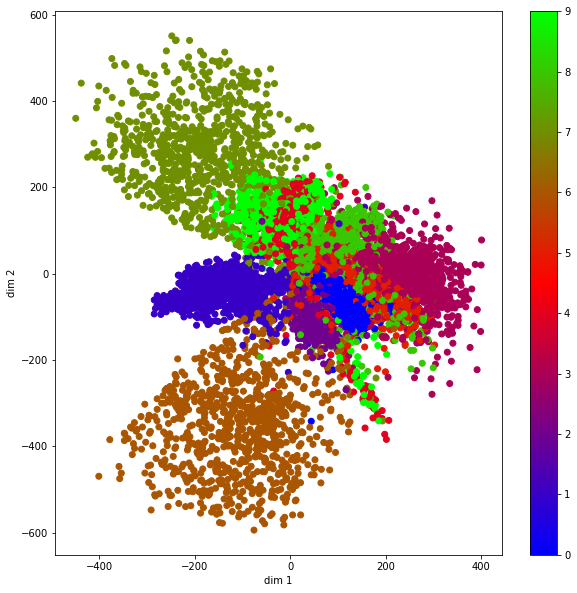

In [12]:
mu, _, _ = encoder.predict(test_images)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=test_labels, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()




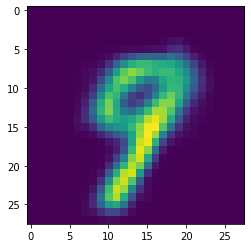

In [13]:
# Visualize images

sample_vector = np.array([[-1,1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

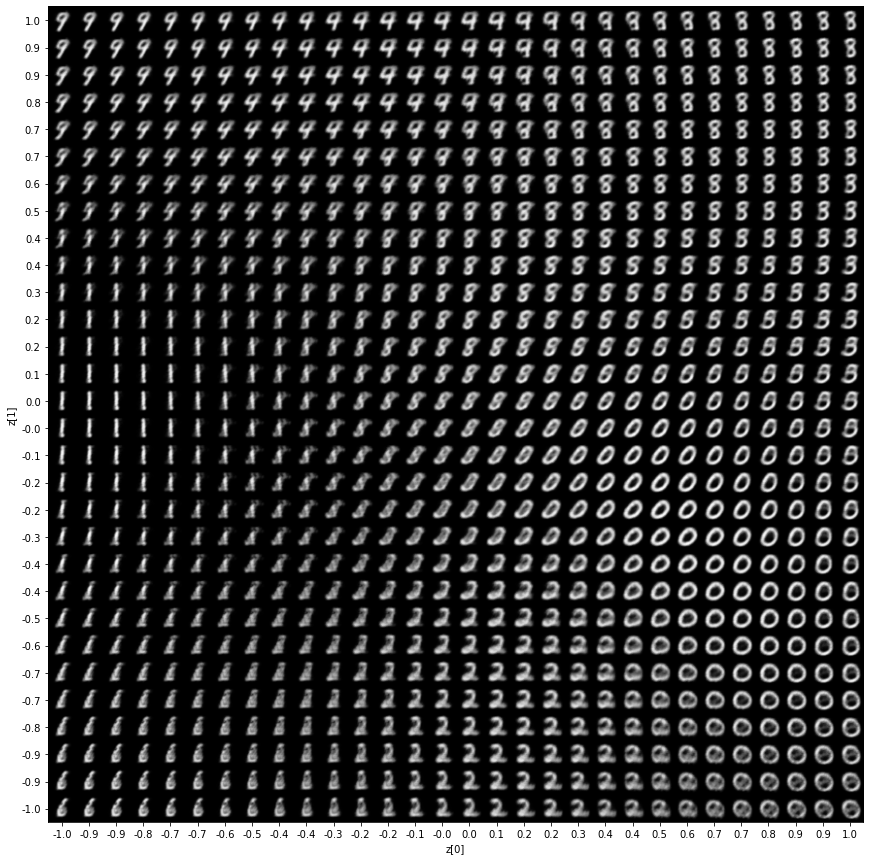

In [14]:
def plot_latent_space( decoder,n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(decoder)

In [15]:
def sample_from_model(dec,n_samples,scale=(-4,4)):
  grid_x = np.linspace(scale[0],scale[1],n_samples)
  grid_y = np.linspace(scale[0],scale[1],n_samples)[::-1]

  samples = list() #np.array()

  for yi in grid_y:
    for xi in grid_x:
      #print("xi={} and yi={}".format(xi,yi))
      z_sample = np.array([[xi,yi]])
      x_decoded = dec.predict(z_sample)
      digit = x_decoded[0].reshape(28,28)
      samples.append(digit)
      #print("x_decoded[0]",x_decoded[0])
      #print("x_decoded[1]",x_decoded[1])
      #print("Tf.shape: ",tf.shape(x_decoded))
      #print("Tf.shape[0]: ",tf.shape(x_decoded[0]))

  return samples

  


In [16]:
model_sample = sample_from_model(decoder,10)
len(model_sample)

100

In [17]:
model_sample = np.array(model_sample)
print(model_sample.shape)
model_sample = model_sample.reshape(100,-1)

(100, 28, 28)


In [18]:
variance_array = np.empty(784)
variance_array.fill(0.1)
#variance_array
variance_array.dtype
variance_array = variance_array.astype(np.float32)
variance_array.dtype

dtype('float32')

In [19]:
def compute_prob(mod_samp,test_img,variance_array):
  probs_list = list()
  for m_img in mod_samp:
    #print(m_img.dtype)
    dist = tfp.distributions.MultivariateNormalDiag(loc=m_img,scale_diag=variance_array)
    probs_list.append(dist.log_prob(test_img))
  
  return np.mean(probs_list)


In [20]:
test_probs = list()
for img in test_img[:100]:
  prob = compute_prob(model_sample,img.reshape(1,-1),variance_array)
  print(prob)
  test_probs.append(prob)

-2647.7236
-4300.3257
-2112.081
-4259.611
-2812.2073
-2263.0232
-2963.1965
-2920.4075
-4191.7456
-3314.473
-4111.111
-3434.1978
-2929.2825
-3837.551
-2809.7568
-3426.824
-3071.4216
-3123.041
-4383.3413
-2420.6436
-3087.3523
-3184.6038
-3200.9812
-3102.5874
-2207.9478
-6149.743
-2493.189
-3013.278
-4123.8296
-2624.0767
-2926.8484
-2428.3745
-3410.3696
-3938.1611
-3115.535
-3952.6682
-2983.4985
-2618.7158
-2808.7788
-2751.7366
-2158.7957
-2367.9482
-2958.0527
-2771.3096
-2756.2532
-2775.8188
-2916.6238
-2635.9038
-4285.252
-3150.7847
-2920.6572
-4096.008
-3083.8528
-2761.7324
-4399.5557
-3694.1074
-3584.8638
-2183.5232
-3053.531
-2457.2163
-3636.7659
-3794.9539
-2442.2546
-2907.8572
-3356.8362
-2294.5503
-2963.643
-3117.6833
-3863.797
-4036.7302
-3199.3584
-5335.2856
-4004.6755
-3209.6733
-2591.7554
-2878.1174
-2667.7903
-2536.5845
-2609.6921
-3975.115
-2966.6497
-3564.9587
-4253.43
-2624.626
-3345.0315
-4021.431
-2920.5403
-3615.2576
-3749.4084
-2447.7
-3116.7822
-3111.116
-2269.082
-37

In [21]:
def gen_encoder_1(latent_dim):
  input = tf.keras.layers.Input(shape=(28, 28, 1))
  x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(input)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  # x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
  # x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  # x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

  enc_shape = tf.shape(x)
  #print(enc_shape)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(32, activation='relu')(x)

  z_mu = tf.keras.layers.Dense(latent_dim)(x)
  z_sigma = tf.keras.layers.Dense(latent_dim)(x) 

  z = reparameterize(z_mu, z_sigma)

  encoder = tf.keras.Model(input, [z_mu, z_sigma,z], name='encoder_1')
  #print(encoder.summary())

  return enc_shape,encoder

enc_shape,encoder_1 = gen_encoder_1(2)
encoder_1.summary()
#print("enc_shape: ",enc_shape)

Model: "encoder_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       max_pooling2d_3[0][0]            
__________________________________________________________________________________________

In [22]:
def gen_decoder_1(latent_dim):
  input = tf.keras.layers.Input(shape=(latent_dim, ))
  x = tf.keras.layers.Dense(7* 7 * 64, activation='relu')(input)
 
  x = tf.keras.layers.Reshape((7, 7, 64))(x)

  x = tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=3, padding='same', activation='relu',strides=(2, 2))(x)
  
  x = tf.keras.layers.Conv2DTranspose(8, 3, padding='same', activation='relu',strides=(2, 2))(x)
  
  x = tf.keras.layers.Conv2DTranspose(1, 3, padding='same', activation='relu')(x)
    
  decoder_1 = tf.keras.Model(input, x,name="decoder_1")
  return decoder_1

decoder_1 = gen_decoder_1(2)
decoder_1.summary()

Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 8)         4616      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         73        
Total params: 14,681
Trainable params: 14,681
Non-trainable params: 0
_____________________________________________________

In [23]:
train_step(encoder_1,decoder_1,10)

epoch:0 Loss:182.74559020996094
epoch:1 Loss:171.04412841796875
epoch:2 Loss:175.13706970214844
epoch:3 Loss:167.81907653808594
epoch:4 Loss:165.47898864746094
epoch:5 Loss:160.7203826904297
epoch:6 Loss:163.3880615234375
epoch:7 Loss:154.4389190673828
epoch:8 Loss:156.4527587890625
epoch:9 Loss:173.20989990234375


In [24]:
decoder_1.trainable_variables

[<tf.Variable 'dense_7/kernel:0' shape=(2, 3136) dtype=float32, numpy=
 array([[-0.00038522,  0.0087542 ,  0.01583245, ...,  0.01185948,
          0.06196453,  0.14351588],
        [ 0.00401899, -0.00534733, -0.02642509, ...,  0.01712547,
         -0.11403108, -0.14063835]], dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(3136,) dtype=float32, numpy=
 array([-0.02632777, -0.06072787,  0.17224614, ..., -0.02901509,
        -0.01390161,  0.13501878], dtype=float32)>,
 <tf.Variable 'conv2d_transpose_3/kernel:0' shape=(3, 3, 8, 64) dtype=float32, numpy=
 array([[[[-7.81705528e-02, -1.60465054e-02,  6.63772225e-02, ...,
            6.03374988e-02, -1.07858285e-01, -8.33922401e-02],
          [-9.71231535e-02,  9.76504236e-02, -3.68437096e-02, ...,
           -9.51461866e-02, -9.26091075e-02, -1.16366476e-01],
          [-1.20488264e-01,  2.78050691e-04, -2.57322341e-02, ...,
           -1.52624905e-01, -2.09402040e-01, -5.10967374e-02],
          ...,
          [-6.78505749e-03, -7.5

In [25]:
decoder.trainable_variables

[<tf.Variable 'dense_3/kernel:0' shape=(2, 3136) dtype=float32, numpy=
 array([[ 5.01765637e-03,  1.45897679e-02,  1.16921365e-02, ...,
          6.62522204e-03, -4.90178136e-05,  3.86269484e-03],
        [-3.79487647e-05, -4.26981300e-02, -6.96995808e-03, ...,
         -7.59713817e-03,  2.98505300e-03,  4.34341980e-03]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(3136,) dtype=float32, numpy=
 array([-0.0181846 , -0.02879971, -0.04457641, ..., -0.03379807,
        -0.04336856, -0.02875758], dtype=float32)>,
 <tf.Variable 'conv2d_transpose/kernel:0' shape=(3, 3, 32, 64) dtype=float32, numpy=
 array([[[[-0.03981619,  0.17096075, -0.04940948, ...,  0.07722922,
            0.00898668,  0.03056899],
          [ 0.02270607,  0.03872511, -0.10356453, ...,  0.10841872,
           -0.1659029 ,  0.22975206],
          [ 0.008183  ,  0.00375329,  0.01376609, ...,  0.12420012,
            0.05462314, -0.07383542],
          ...,
          [ 0.04021895, -0.16369295, -0.0164238 , ...,  0

In [26]:
model_sample_1 = sample_from_model(decoder_1,10)

In [27]:
model_sample_1 = np.array(model_sample_1)
print(model_sample_1.shape)
model_sample_1 = model_sample.reshape(100,-1)
print(model_sample_1.shape)

(100, 28, 28)
(100, 784)


In [28]:
print(id(model_sample))
print(id(model_sample_1))

140541972537792
140539173060000


In [29]:
model_sample == model_sample_1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [30]:
test_probs_1 = list()
for img in test_img[:100]:
  prob = compute_prob(model_sample_1,img.reshape(1,-1),variance_array)
  print(prob)
  test_probs_1.append(prob)

-2647.7236
-4300.3257
-2112.081
-4259.611
-2812.2073
-2263.0232
-2963.1965
-2920.4075
-4191.7456
-3314.473
-4111.111
-3434.1978
-2929.2825
-3837.551
-2809.7568
-3426.824
-3071.4216
-3123.041
-4383.3413
-2420.6436
-3087.3523
-3184.6038
-3200.9812
-3102.5874
-2207.9478
-6149.743
-2493.189
-3013.278
-4123.8296
-2624.0767
-2926.8484
-2428.3745
-3410.3696
-3938.1611
-3115.535
-3952.6682
-2983.4985
-2618.7158
-2808.7788
-2751.7366
-2158.7957
-2367.9482
-2958.0527
-2771.3096
-2756.2532
-2775.8188
-2916.6238
-2635.9038
-4285.252
-3150.7847
-2920.6572
-4096.008
-3083.8528
-2761.7324
-4399.5557
-3694.1074
-3584.8638
-2183.5232
-3053.531
-2457.2163
-3636.7659
-3794.9539
-2442.2546
-2907.8572
-3356.8362
-2294.5503
-2963.643
-3117.6833
-3863.797
-4036.7302
-3199.3584
-5335.2856
-4004.6755
-3209.6733
-2591.7554
-2878.1174
-2667.7903
-2536.5845
-2609.6921
-3975.115
-2966.6497
-3564.9587
-4253.43
-2624.626
-3345.0315
-4021.431
-2920.5403
-3615.2576
-3749.4084
-2447.7
-3116.7822
-3111.116
-2269.082
-37

In [31]:
test_probs == test_probs_1

True